In [8]:
%pylab inline
import os
import shutil

from GAN_utils import *
from keras import Model
from keras.layers import *
from keras.optimizers import *
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['maximum', 'dot', 'average', 'copy', 'subtract', 'get', 'multiply', 'add', 'minimum', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
normalized_transactions_filepath = "../../datasets/berka_dataset/usable/normalized_transactions_100.npy"

transactions = np.load(normalized_transactions_filepath)
np.random.shuffle(transactions)
N, D = transactions.shape
print(N, D)

53888 100


In [4]:
class GAN:
    def __init__(self, timesteps, latent_dim):
        self._timesteps = timesteps
        self._latent_dim = latent_dim

    def build_model(self, lr):
        self._generator = self._build_generator(self._latent_dim, self._timesteps)

        self._discriminator = self._build_discriminator(self._timesteps)
        self._discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr))
        
        z = Input(shape=(self._latent_dim, ))
        fake = self._generator(z)

        set_model_trainable(self._discriminator, False)
        
        valid = self._discriminator(fake)

        self._gan = Model(z, valid, 'GAN')

        self._gan.compile(loss='binary_crossentropy', optimizer=RMSprop(lr))
        
        return self._gan, self._generator, self._discriminator

    def _build_generator(self, noise_dim, timesteps):
        generator_inputs = Input((latent_dim, ))
        generated = generator_inputs
        
        generated = Lambda(lambda x: K.expand_dims(x))(generated)
        while generated.shape[1] < timesteps:
            generated = Conv1D(
                32, 3, activation='relu', padding='same')(generated)
            generated = UpSampling1D(2)(generated)
        generated = Conv1D(
            1, 3, activation='relu', padding='same')(generated)
        generated = Lambda(lambda x: K.squeeze(x, -1))(generated)
        generated = Dense(timesteps, activation='tanh')(generated)

        generator = Model(generator_inputs, generated, 'generator')

        return generator

    def _build_discriminator(self, timesteps):
        discriminator_inputs = Input((timesteps, ))
        discriminated = discriminator_inputs
        
        mbd = MinibatchDiscrimination(5, 3)(discriminated)
        mbd = Dense(1, activation='relu')(mbd)
        
        discriminated = Lambda(lambda x: K.expand_dims(x))(discriminated)
        while discriminated.shape[1] > 1:
            discriminated = Conv1D(32, 3, activation='relu', padding='same')(discriminated)
            discriminated = MaxPooling1D(2, padding='same')(discriminated)
        discriminated = Flatten()(discriminated)
#         discriminated = Dense(32, activation='tanh')(discriminated)
#         discriminated = Dense(15, activation='relu')(discriminated)
#         discriminated = Dense(1, activation='relu')(discriminated) 
        discriminated = Concatenate()([discriminated, mbd])
        discriminated = Dense(1, activation='sigmoid')(discriminated) 

        discriminator = Model(discriminator_inputs, discriminated, 'discriminator')
        return discriminator

    def train(self, batch_size, epochs, n_generator, n_discriminator, dataset,
              img_frequency):
        half_batch = int(batch_size / 2)

        losses = [[], []]
        for epoch in range(epochs):
            for _ in range(n_discriminator):
                indexes = np.random.randint(0, dataset.shape[0], half_batch)
                batch_transactions = dataset[indexes]

                noise = np.random.normal(0, 1, (half_batch, self._latent_dim))

                generated_transactions = self._generator.predict(noise)

                discriminator_loss_real = self._discriminator.train_on_batch(
                    batch_transactions, np.random.uniform(0.66, 1, (half_batch, 1)))
                discriminator_loss_fake = self._discriminator.train_on_batch(
                    generated_transactions, np.random.uniform(0, 0.33, (half_batch, 1)))
                discriminator_loss = 0.5 * np.add(discriminator_loss_real,
                                                  discriminator_loss_fake)

            for _ in range(n_generator):
                noise = np.random.normal(0, 1, (batch_size, latent_dim))

                generator_loss = self._gan.train_on_batch(
                    noise, np.ones((batch_size, 1)))

            losses[0].append(generator_loss)
            losses[1].append(discriminator_loss)

            print("%d [D loss: %f] [G loss: %f]" % (epoch, discriminator_loss,
                                                    generator_loss))

            if epoch % img_frequency == 0:
                self._save_imgs(epoch)
                self._save_losses(losses)

    def _save_imgs(self, epoch):
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, latent_dim))
        generated_transactions = self._generator.predict(noise)

        plt.subplots(rows, columns, figsize=(15, 5))
        k = 1
        for i in range(rows):
            for j in range(columns):
                plt.subplot(rows, columns, k)
                plt.plot(generated_transactions[k - 1])
                plt.xticks([])
                plt.yticks([])
                plt.ylim(-1, 1)
                k += 1
        plt.tight_layout()
        plt.savefig('gan/%05d.png' % epoch)
        plt.savefig('gan/last.png')
        plt.close()

    @staticmethod
    def _save_losses(losses):
        plt.plot(losses[0])
        plt.plot(losses[1])
        plt.legend(['generator', 'discriminator'])
        plt.savefig('gan/losses.png')
        plt.close()

In [5]:
timesteps = 100
batch_size = 64
epochs = int(1e5)
n_discriminator = 1
n_generator = 5
latent_dim = 2
lr = 0.0001
img_frequency = 250
timesteps = timesteps

In [6]:
if os.path.exists('gan'):
    shutil.rmtree('gan')
os.makedirs('gan')

/home/luca/.local/lib/python3.5/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 7.672433] [G loss: 0.001448]


KeyboardInterrupt: 

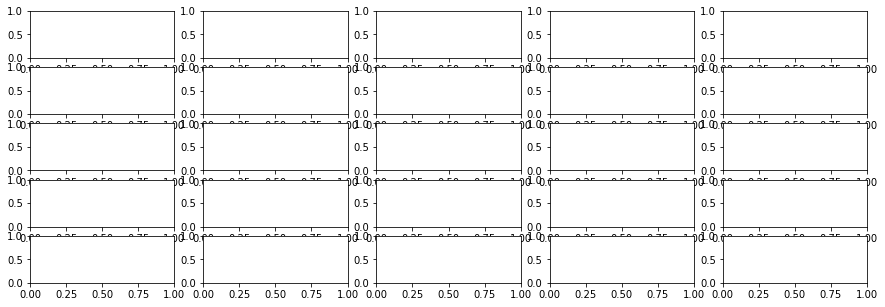

In [9]:
gan = GAN(timesteps, latent_dim)
gan.build_model(lr)
gan.train(batch_size, epochs, n_generator, n_discriminator, transactions, img_frequency)